<a href="https://colab.research.google.com/github/sunandhini96/ERA_S7/blob/main/ERA1S7Model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model 1 :
Dataset : MNIST
Applied : created skeleton model and also applied batch normalization to each layer.

In [1]:
!git clone "https://github.com/sunandhini96/ERA_S7.git"

Cloning into 'ERA_S7'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 33 (delta 12), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (33/33), 84.10 KiB | 10.51 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [2]:
cd /content/ERA_S7

/content/ERA_S7


In [3]:
pwd

'/content/ERA_S7'

In [4]:
!python model.py

In [5]:
from model import *

# Import Libraries

In [6]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [7]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [8]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 281361823.72it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 42031816.04it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 179596224.07it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22924824.03it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [9]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=32)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Summary of the model

In [10]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model_1().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
              ReLU-2           [-1, 12, 26, 26]               0
       BatchNorm2d-3           [-1, 12, 26, 26]              24
            Conv2d-4           [-1, 16, 24, 24]           1,728
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 10, 24, 24]             160
         MaxPool2d-8           [-1, 10, 12, 12]               0
            Conv2d-9           [-1, 12, 10, 10]           1,080
             ReLU-10           [-1, 12, 10, 10]               0
      BatchNorm2d-11           [-1, 12, 10, 10]              24
           Conv2d-12             [-1, 12, 8, 8]           1,296
             ReLU-13             [-1, 12, 8, 8]               0
      BatchNorm2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [11]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [13]:
from torch.optim.lr_scheduler import StepLR

model =  Model_1().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    #scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.04942340403795242 Batch_id=937 Accuracy=92.77: 100%|██████████| 938/938 [00:20<00:00, 45.38it/s]



Test set: Average loss: 0.1007, Accuracy: 9708/10000 (97.08%)

EPOCH: 1


Loss=0.05280555412173271 Batch_id=937 Accuracy=98.18: 100%|██████████| 938/938 [00:19<00:00, 47.22it/s]



Test set: Average loss: 0.0368, Accuracy: 9887/10000 (98.87%)

EPOCH: 2


Loss=0.008415513671934605 Batch_id=937 Accuracy=98.59: 100%|██████████| 938/938 [00:20<00:00, 44.82it/s]



Test set: Average loss: 0.0337, Accuracy: 9904/10000 (99.04%)

EPOCH: 3


Loss=0.03257976472377777 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [00:19<00:00, 47.17it/s]



Test set: Average loss: 0.0314, Accuracy: 9906/10000 (99.06%)

EPOCH: 4


Loss=0.05680623650550842 Batch_id=937 Accuracy=98.85: 100%|██████████| 938/938 [00:20<00:00, 46.19it/s]



Test set: Average loss: 0.0360, Accuracy: 9887/10000 (98.87%)

EPOCH: 5


Loss=0.009116838686168194 Batch_id=937 Accuracy=98.96: 100%|██████████| 938/938 [00:21<00:00, 44.23it/s]



Test set: Average loss: 0.0283, Accuracy: 9920/10000 (99.20%)

EPOCH: 6


Loss=0.040418628603219986 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:21<00:00, 43.16it/s]



Test set: Average loss: 0.0239, Accuracy: 9921/10000 (99.21%)

EPOCH: 7


Loss=0.012258580885827541 Batch_id=937 Accuracy=99.15: 100%|██████████| 938/938 [00:20<00:00, 44.82it/s]



Test set: Average loss: 0.0255, Accuracy: 9915/10000 (99.15%)

EPOCH: 8


Loss=0.005347209516912699 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:19<00:00, 47.32it/s]



Test set: Average loss: 0.0248, Accuracy: 9923/10000 (99.23%)

EPOCH: 9


Loss=0.002950513269752264 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [00:20<00:00, 46.30it/s]



Test set: Average loss: 0.0334, Accuracy: 9889/10000 (98.89%)

EPOCH: 10


Loss=0.03483585640788078 Batch_id=937 Accuracy=99.29: 100%|██████████| 938/938 [00:21<00:00, 44.11it/s]



Test set: Average loss: 0.0241, Accuracy: 9930/10000 (99.30%)

EPOCH: 11


Loss=0.03235429897904396 Batch_id=937 Accuracy=99.30: 100%|██████████| 938/938 [00:21<00:00, 44.31it/s]



Test set: Average loss: 0.0288, Accuracy: 9910/10000 (99.10%)

EPOCH: 12


Loss=0.0029859875794500113 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [00:19<00:00, 47.40it/s]



Test set: Average loss: 0.0204, Accuracy: 9934/10000 (99.34%)

EPOCH: 13


Loss=0.006023637484759092 Batch_id=937 Accuracy=99.36: 100%|██████████| 938/938 [00:20<00:00, 44.75it/s]



Test set: Average loss: 0.0220, Accuracy: 9932/10000 (99.32%)

EPOCH: 14


Loss=0.023460283875465393 Batch_id=937 Accuracy=99.43: 100%|██████████| 938/938 [00:21<00:00, 44.12it/s]



Test set: Average loss: 0.0219, Accuracy: 9932/10000 (99.32%)



# Let's Train and test our model

This time let's add a scheduler for out LR.

Text(0.5, 1.0, 'Test Accuracy')

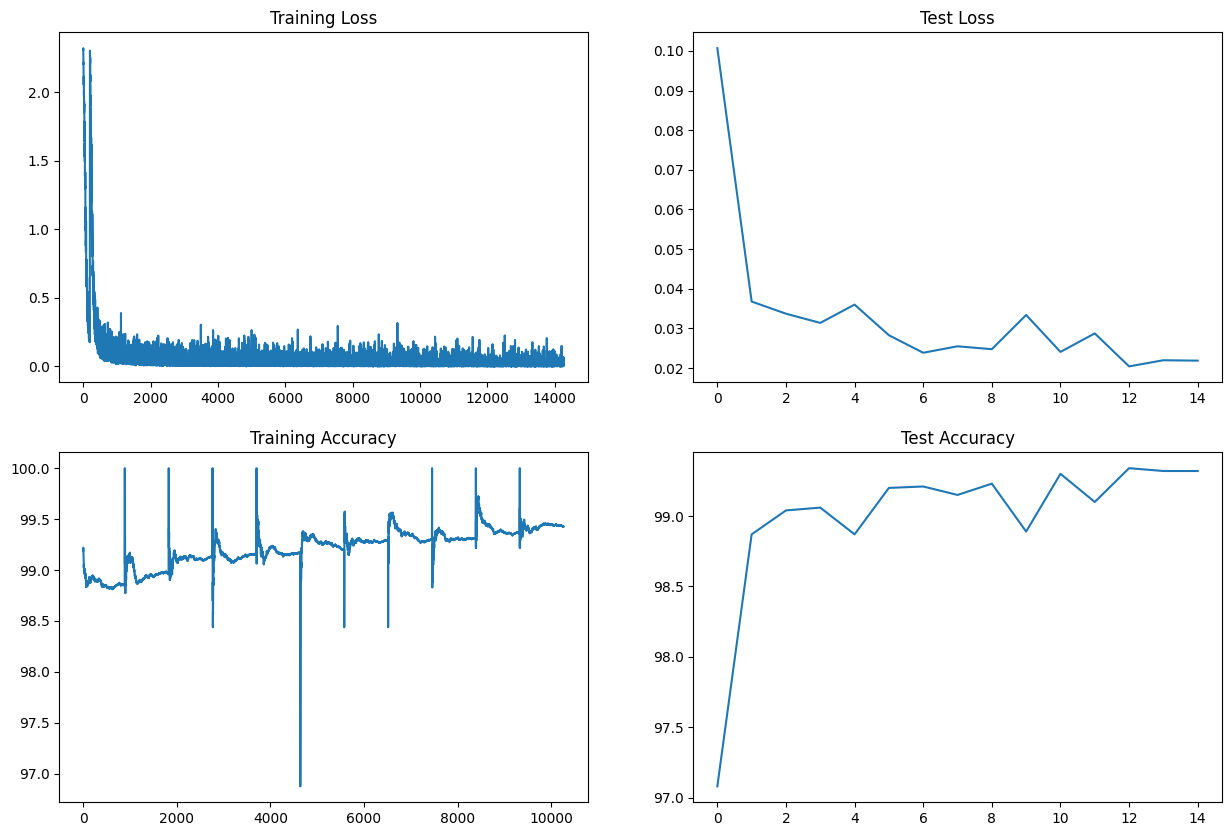

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
t=[t.cpu().item() for t in train_losses]
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Target:
-> Created the model skeleton and also applied batch normalization
## Results:
-> Parameters: 7.7k

-> Best Train Accuracy: 99.43

-> Best Test Accuracy: 99.34 (12th Epoch)

## Analysis:
-> model is underfitting at starting but after few epochs model is overfitting. We are getting best test accuracy around 99.34 % but still we are not getting our target accuracy 99.4 % within 15 epochs.  